# Motor Imagery EEG-BCIs - 0 to Deep Learning with BCI-IV 2a dataset

@author: João Araújo ([LinkedIn](https://www.linkedin.com/in/joao-araujo-60470193/))

## 1 - Quick visualization + Building dataset
The goal of this short notebook is to provide an introduction to EEG data visualization on the BCI-IV 2a dataset. Specifically for this notebook, we will need a single 'gdf' file from subject A01 that you can get [here](https://www.bbci.de/competition/iv/#dataset2a). This is a mere example as, in practice, you should check every participant's data. We will further raise some awareness to potential artifacts like blinks and eye movements and provide a simple way to account for these. Then, we will build the final dataset we will develop our models for.

---

Let's start with the imports. This tutorial was developed and tested in [Spyder IDE](https://www.spyder-ide.org/), with the [Notebook](https://docs.spyder-ide.org/current/plugins/notebook.html) plugin installed. This environment will provide the best experience using these notebooks. Using qt as the backend for plot generation is also recommended.

In [31]:
# Imports
import mne
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

# Prepare MNE for notebook visualization
mne.viz.set_3d_backend("notebook")

# Use QT backend for MNE plots. Will pop-up windows for each figure
%matplotlib qt

# Use inline plotting if you prefer. Will limit interaction with plots
#%matplotlib inline


# Insert directory where your BCI IV 2a gdf files are
os.chdir(r'C:\Users\João Araújo\Desktop\BCI_datasets\BCICIV_2a_gdf')

### Read file and plot with MNE
The MNE library has a useful function that allows to extract data from GDF files called `read_raw_gdf()` and allows direct plotting of our data by calling `.plot()` directly from the read raw gdf object we have created

In [32]:
# Define filename
filename = 'A01T.gdf'

# Read file
raw = mne.io.read_raw_gdf(filename)

# Plot data
raw.plot()

Extracting EDF parameters from C:\Users\João Araújo\Desktop\BCI_datasets\BCICIV_2a_gdf\A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...


C:\Anaconda\envs\joao\lib\site-packages\mne\io\edf\edf.py:1155: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
C:\Anaconda\envs\joao\lib\contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Channels marked as bad:
none


From these plots we can see that:

- We have 25 electrodes present on these data: 22 of them EEG and 3 EOGs (left, right and center)
- We have a few events being triggered throughout. Taking a look at the dataset [description](https://www.bbci.de/competition/iv/desc_2a.pdf), we can see that:
    - Event 769 - corresponds to a left hand imagery trial
    - Event 770 - corresponds to a right hand imagery trial
    - Event 771 - corresponds to a foot imagery trial
    - Event 772 - corresponds to a tonge imagery trial
- Notice how channels marked as EOG are way more variable and how frontal EEG channels (Fz for instance) are extremely prone to being contaminated with eye blink / movement noise
    
At this point we have several ways to further visualize data. Here we will focus on visualizing the potential artifacts that can be introduced due to EOG and how we can start mitigating them. Let's isolate a single trial to start:

In [33]:
# Original classes code on the paper
classes = [769,770,771,772]

# Get events (they can be accessed from annotations)
events = mne.events_from_annotations(raw)
event_hist = events[0]
classes_dict = events[1]
classes_code = np.zeros(4)

for i in range(len(classes)):
    classes_code[i] = classes_dict[str(classes[i])]

print('Trials '+str(classes)+ ' are coded as '+str(classes_code)+' in the annotations.')

# Variables we will output
TRIAL = None
class_label = None

# We want the whole trial, so 7.5 seconds from when the 'beep' sounds
trial_duration = 7.5 
fs = raw.info['sfreq']
samples = int(trial_duration * fs)

# Get the first motor imagery trial from the events history
Subj_data = raw.get_data()
a = 0
for i in range(len(event_hist)):
    if event_hist[i][2] in classes_code:
        if a == 10:
            event_class = classes[int(np.where(classes_code == event_hist[i][2])[0])]
            event_data = Subj_data[:,event_hist[i][0]:event_hist[i][0]+samples]
            TRIAL = event_data
            class_label = event_class
            break

        else:
            a +=1

print('We just saved a single trial\'s EEG data ( shape: '+str(TRIAL.shape)+' ) from a trial of type: '+str(class_label))

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Trials [769, 770, 771, 772] are coded as [ 7.  8.  9. 10.] in the annotations.
We just saved a single trial's EEG data ( shape: (25, 1875) ) from a trial of type: 769


### Visualizing and plotting trials using Pandas
You have several ways to plot the data without necessarily using MNE tools. For instance you can create a pandas DataFrame with your trial data and use the channel names a columns and plot everything from there. Let's create such Dataframe and plot our left and right EOG channels from our trial

     EEG-Fz     EEG-0     EEG-1  ...      EOG-left  EOG-central  EOG-right
0  0.000021  0.000015  0.000018  ...  5.371094e-06     0.000014   0.000016
1  0.000012  0.000009  0.000010  ...  2.441406e-06     0.000002   0.000011
2  0.000013  0.000014  0.000011  ...  9.765625e-07     0.000014   0.000020
3  0.000007  0.000006  0.000004  ...  1.074219e-05     0.000010   0.000019
4  0.000004  0.000007  0.000001  ...  1.367187e-05     0.000011   0.000006

[5 rows x 25 columns]


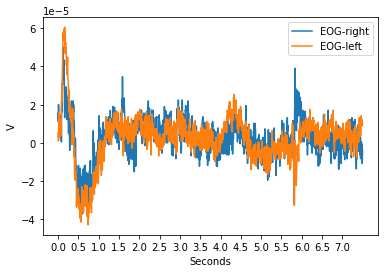

In [34]:
df_trial = pd.DataFrame(data = TRIAL.T, columns = raw.ch_names)
print(df_trial.head())
df_trial['EOG-right'].plot(legend = 'EOG right')
df_trial['EOG-left'].plot(legend = 'EOG left',xlabel='Seconds')
plt.xticks(ticks = np.arange(0,df_trial.shape[0],fs/2), labels = np.arange(0,df_trial.shape[0],fs/2)/fs)
plt.ylabel('V')
plt.show()

Two interesting things can be taken from this plot:

- From seconds 0-1.5 we see a sharp oscillation where both channels are positively correlated. While the amplitude of this oscillation is not that large, this is the usual profile of a **blink** artifact.
- From seconds 5.5 to 6.5 we have a very slight low-frequency signal oscillation where both EOGs are highly negatively correlated. This is the usual profile of a slight sideways or up-down **eye movement** (check this quite old [paper](https://www.sciencedirect.com/science/article/pii/001346949190154V) if interested).

In the next plots we can compare how much of this artifact shared variance a frontal EEG electrode (like Fz) has compared to a central (like Cz) one.

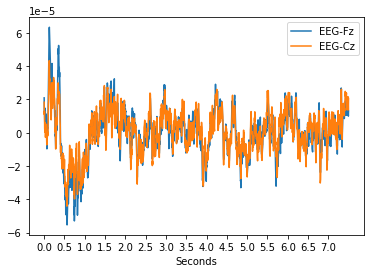

In [35]:
df_trial['EEG-Fz'].plot(legend = 'EEG-Fz')
df_trial['EEG-Cz'].plot(legend = 'EEG-Cz',xlabel='Seconds')
plt.xticks(ticks = np.arange(0,df_trial.shape[0],fs/2), labels = np.arange(0,df_trial.shape[0],fs/2)/fs)
plt.show()

### Removing EOG artifacts by filtering
To remove EOG noise you can try to apply [ICA](https://mne.tools/stable/generated/mne.preprocessing.ICA.html) or the method in the hackathon description [here](https://www.sciencedirect.com/science/article/pii/S1388245706014313). Another option for us it to design an high-pass low-frequency filter and filter out general low frequency noise. A common filter design choice for EEG is a [Butterworth filter](https://en.wikipedia.org/wiki/Butterworth_filter) and a zero-phase filtering procedure is used:

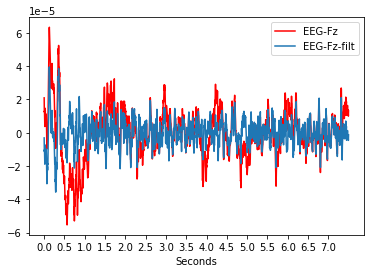

In [36]:
# Imports
from scipy.signal import butter, sosfiltfilt

# Define your High-pass frequency (above 3 Hz here) and filter order
filter_order = 6
cutoff_freq = 3

# Define a filter. We choose a Butterworth filter architecture
butter_sos = butter(N = filter_order, 
                    Wn = cutoff_freq, 
                    btype = 'high',
                    analog = False,
                    output = 'sos',
                    fs = fs)

# Add a filtered Fz channel to the dataframe
df_trial['EEG-Fz-filt'] = sosfiltfilt(butter_sos, df_trial['EEG-Fz'], axis = -1)

# Compare filtered / unfiltered channels
df_trial['EEG-Fz'].plot(legend = 'EEG-Fz', color='r')
df_trial['EEG-Fz-filt'].plot(legend = 'EEG-Fz-filt',xlabel='Seconds')
plt.xticks(ticks = np.arange(0,df_trial.shape[0],fs/2), labels = np.arange(0,df_trial.shape[0],fs/2)/fs);
plt.show()

Notice how we managed to significantly lower the noise of the blink and completely remove the lateral eye movement.

---

### Plotting Event-Related Desynchronisation
If we believe we can classify different types of motor imagery using changes in oscillatory activity across specific frequencies - Event-Related (De-)synchronisation - it is useful to plot the trial's magnitude profile across frequencies. Ideally, we want to see specific changes when the motor imagery stage happens in the paradigm (3-6 seconds post auditory cue). For this we have two things we can plot:

- **Signal's Power Spectrum**: Will give you the signal power across our frequency domain
- **Spectrogram**: Will give you the signal power across frequencies and also across time. So you can have an idea when signal changes in the frequency magnitude domain start to happen within each trial.

Let's pick our Cz EEG channel to analyse:

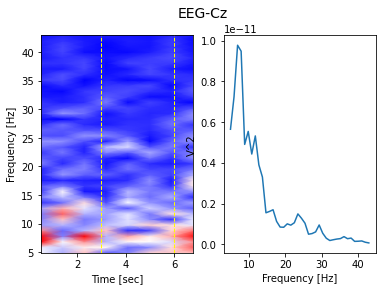

In [37]:
# Imports
from scipy.signal import welch, spectrogram

# Pick EEG channel from raw.ch_names
channel = 'EEG-Cz'

# Calculate Spectrogram
f_S, t, Sxx = spectrogram( x=df_trial[channel],
                         fs=fs, 
                         window='hann',
                         noverlap=None,
                         detrend='constant',
                         scaling='spectrum', 
                         axis=- 1, 
                         mode='magnitude')

# Calculate Power Spectrum
f_P, Pxx = welch(x=df_trial[channel], 
               fs=fs, 
               window='hann', 
               noverlap=None,
               detrend='constant',
               scaling='spectrum',
               axis=- 1, 
               average='mean')

# Plot PSD and Spectrogram side by side
fig, (ax1, ax2) = plt.subplots(1, 2)

# Plot Spectrogram
cmap = plt.get_cmap('bwr') # blue < white < red
ax1.pcolormesh(t, f_S[5:45], Sxx[5:45,:], cmap = cmap, shading='gouraud')
ax1.set_ylabel('Frequency [Hz]')
ax1.set_xlabel('Time [sec]')
# plot lines to mark the start and end of motor imagery stage (3- and 6-second mark)
ax1.plot([3,3], 
         [min(f_S[5:45]),max(f_S[5:45])], 
         color='yellow', 
         linestyle='dashed', 
         linewidth=1)

ax1.plot([6,6], 
         [min(f_S[5:45]),max(f_S[5:45])], 
         color='yellow', 
         linestyle='dashed', 
         linewidth=1)

# Plot Power Spectrum
ax2.plot(f_P[5:45],Pxx[5:45])
ax2.set_xlabel('Frequency [Hz]')
ax2.set_ylabel('V^2')

fig.suptitle(channel, fontsize=14)

plt.show()

For this particular trial and subject we can conclude that:

- Most changes in the frequency domain are happening between 7-35Hz, as expected for sensorimotor tasks
- There is a strong desynchronisation at the 8-9Hz band when the subject is doing motor imagination (between 3 and 6 seconds)

---

## Building our Dataset
OK - time to build our dataset and take into account what we learned from these plots. For this we are actually going to use the `.mat` version of the BCI IV 2a files provided [here](http://bnci-horizon-2020.eu/database/data-sets). This is because they contain the labels for the original "Evaluation" files for each subject (while the gdf versions do not). These `.mat` files contain the following information on each one of the 6 experimental runs for each subject:

- **X**: Session data. Shape = (n_channels, timepoints)
- **triggers**: EEG sample aligned with beep onset. Shape = (n_trials,)
- **y**: Motor Imagery class label. Shape = (n_trials,)
- **artifact**: boolean vector, true entries for noisy trials. Shape = (n_trials,)


Our goals are:

- Generate a reshaped `DATA` dataset (`M_res`) of shape (n_trials, n_channels, n_timepoints) ready to be used to train and validate our models
- Generate 2 extra vectors `subj_labels` and `class_labels` that will track the subject ID and the type of imagery for each trial respectively

while we do:

- Pre-processing of the data, filtering out unwanted frequency bands and not including trials with artifacts.
- We do not get all data from the trials but mostly where the subject is actually performing imgery
- Remove EOG channels from our workable dataset

We can also achieve all this without using MNE. Once you download all the files and edit the directory on the script below, you should end up with a single `.mat` file containing a dictionary of our 3D Matrix and 2 vectors of interest.

In [41]:
# Imports
import glob
from scipy.io import loadmat,savemat

# Variables we will output
DATA = []           
subj_labels = []    
class_labels = [] 

## Pre-Processing ##
# channel indices for EEG rather than EOG
eeg_channels = np.arange(22)

# Bandpass noise digital filter
filter_order = 6
fs = 250
cutoff_freqs = np.array([3,40])
butter_sos = butter(N = filter_order, 
                    Wn = cutoff_freqs, 
                    btype = 'bandpass',
                    analog = False,
                    output = 'sos',
                    fs = fs)

# EDIT THIS LINE: Insert directory where your BCI IV 2a mat files are
os.chdir(r'C:\Users\João Araújo\Desktop\BCI_datasets\BCICIV_2a_gdf')

# Go through all files
for filename in glob.glob("*.mat"):
    print('Retrieving data from '+filename+'...')
    
    # Get data
    subj_name = filename[:3]
    raw = loadmat(filename)
    raw = np.squeeze(raw['data'])
    
    # Go through the subjects sessions of interest and build dataset
    for i in range(np.size(raw)-6,np.size(raw)):
        
        # Convert from a MATLAB struct to something readable in python
        X = raw[i][0][0][0].T                           # Session data
        triggers = np.squeeze(raw[i][0][0][1])          # EEG sample aligned with the beep
        y = np.squeeze(raw[i][0][0][2])                 # class labels
        artifact = np.squeeze(raw[i][0][0][5]) == True  # Array of artifact presence evaluated by experts
        
        # Add our 2 second offset to the trigger sample get data 2s after beep
        mi_offset = int(2 * fs)
        triggers += mi_offset
        mi_duration = int(4*fs) # 6s - 2s

        # Go through each run of each session
        for i in range(len(y)):
            # Only add artifact-free trials
            if not artifact[i]:
                
                # Remove unwanted frequencies from the signal using 0-phase filtering
                X_filtered = sosfiltfilt(butter_sos, X, axis = -1)
                
                # Get the event EEG data
                event_data = X_filtered[eeg_channels,triggers[i]:triggers[i] + mi_duration]
                
                # Add data to dataset, and subject/class labels to our vectors of interest
                if np.size(DATA) == 0:
                    DATA = event_data
                    subj_labels = [subj_name]
                    class_labels = [y[i]]
                else:
                    DATA = np.concatenate((DATA,event_data), axis = 1)
                    subj_labels = np.concatenate((subj_labels,[subj_name]))
                    class_labels = np.concatenate((class_labels,[y[i]]))

# Reshape DATA to a reshaped 3D matrix (number_trials x n_channels x trial_len)
M_res = np.reshape(DATA.T,(mi_duration,int(DATA.shape[1]/mi_duration),DATA.shape[0]), order = 'F')
M_res = np.moveaxis(M_res,1,0)
M_res = np.moveaxis(M_res,2,1)

# Save our new .mat file
dataset_dict = {'M_res' : M_res,
'subj_labels' : subj_labels,
'class_labels' : class_labels}

savemat('BCI_IV_2a.mat',dataset_dict)


Retrieving data from A01E.mat...
Retrieving data from A01T.mat...
Retrieving data from A02E.mat...
Retrieving data from A02T.mat...
Retrieving data from A03E.mat...
Retrieving data from A03T.mat...
Retrieving data from A04E.mat...
Retrieving data from A04T.mat...
Retrieving data from A05E.mat...
Retrieving data from A05T.mat...
Retrieving data from A06E.mat...
Retrieving data from A06T.mat...
Retrieving data from A07E.mat...
Retrieving data from A07T.mat...
Retrieving data from A08E.mat...
Retrieving data from A08T.mat...
Retrieving data from A09E.mat...
Retrieving data from A09T.mat...


### Next up: Computational Modeling
Now we have a structured dataset ready to be worked with for modelling. I will address a way to think about modelling BCI data (the way I think about it anyway) on the next notebook.